In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
from pandas import DataFrame
import pandas

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

n_step = 8

dataset = read_csv('pm2.5_non_normalised.csv', header=0, index_col=0)
# print(dataset)
dataset = series_to_supervised(dataset, n_step, 1)
values = dataset.values
#print(values)


n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(train.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_step))
test_X = test_X.reshape((test_X.shape[0], n_step))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#print(train_X)

(35040, 9)
(35040, 8) (35040,) (8751, 8) (8751,)


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Network
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=n_step))
model.add(Dense(256, activation='relu', input_dim=n_step))
model.add(Dense(512, activation='relu', input_dim=n_step))
model.add(Dense(256, activation='relu', input_dim=n_step))
model.add(Dense(64, activation='relu', input_dim=n_step))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 8751 samples
Epoch 1/100
 - 5s - loss: 16.7127 - val_loss: 17.7862
Epoch 2/100
 - 4s - loss: 14.0515 - val_loss: 13.9920
Epoch 3/100
 - 4s - loss: 14.1885 - val_loss: 17.2004
Epoch 4/100
 - 4s - loss: 14.0324 - val_loss: 12.7800
Epoch 5/100
 - 4s - loss: 13.8165 - val_loss: 13.4006
Epoch 6/100
 - 4s - loss: 13.8776 - val_loss: 12.1505
Epoch 7/100
 - 4s - loss: 14.0509 - val_loss: 12.1494
Epoch 8/100
 - 4s - loss: 13.6603 - val_loss: 12.0834
Epoch 9/100
 - 4s - loss: 13.5902 - val_loss: 13.8532
Epoch 10/100
 - 4s - loss: 13.6914 - val_loss: 12.0959
Epoch 11/100
 - 4s - loss: 13.7983 - val_loss: 12.0954
Epoch 12/100
 - 4s - loss: 13.5139 - val_loss: 12.1253
Epoch 13/100
 - 4s - loss: 13.5926 - val_loss: 12.4518
Epoch 14/100
 - 4s - loss: 13.3910 - val_loss: 12.1923
Epoch 15/100
 - 4s - loss: 13.5193 - val_loss: 12.2175
Epoch 16/100
 - 4s - loss: 13.3829 - val_loss: 12.2873
Epoch 17/100
 - 4s - loss: 13.5365 - val_loss: 12.0798
Epoch 18/100
 - 4s - loss

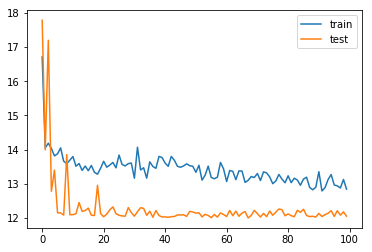

In [0]:
# plot history
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# from math import sqrt
# from numpy import concatenate
# #from numpy import scaler
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error

# # make a prediction
# print(test_X.shape)
# # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
# scaler = StandardScaler()
# scaler.fit(test_X)
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print(rmse)

# # print(test_y)
# # print(yhat)

In [0]:
yhat = model.predict(test_X)
print(test_y[:-1])
print(yhat[1:])

rms = sqrt(mean_squared_error(yhat[1:], test_y[:-1]))
print(rms)

[58.350097 33.199195 51.307846 ...  8.048289 10.060362 10.060362]
[[53.519737]
 [30.812595]
 [54.059525]
 ...
 [ 9.045184]
 [10.880514]
 [10.964244]]
9.802411337965012


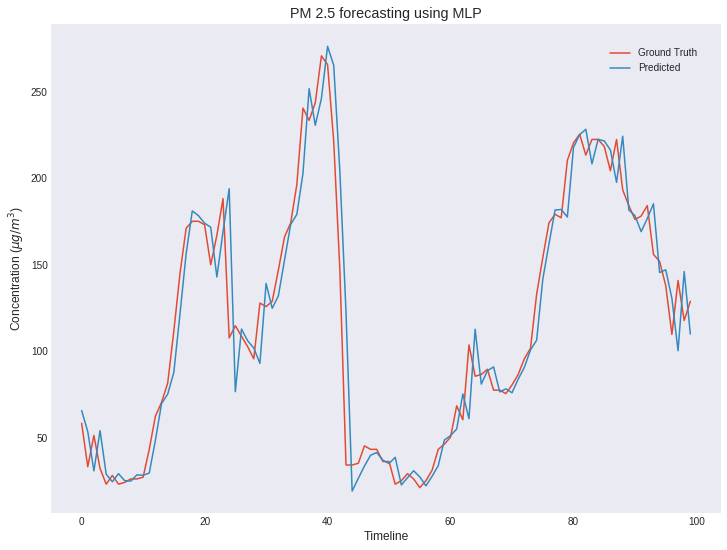

In [0]:
import matplotlib.pyplot as plt

plt.plot(test_y[:100], label="Ground Truth")
plt.plot( yhat[:100], label="Predicted")


plt.style.use('seaborn-dark')
plt.ylabel("Concentration ($\mu g / m^3$)")
plt.xlabel("Timeline")
plt.legend(loc="upper right", borderaxespad=2)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.title("PM 2.5 forecasting using MLP")

plt.show()